# Abu Dhabi Rental Price Prediction using Structural & Location based Features

### Problem Statement
Rental pricing depends on complex interactions between property characteristics and neighborhood effects. Traditional linear models may struggle to capture these dynamics.
This project develops and compares multiple machine learning models to predict annual rental prices for residential properties in Abu Dhabi

### Research Question
How do structural property charachteristics & neighbourhood level location information influence rental pricing in Abu Dhabi & which modeling approach provides the most reliable predictive performance? 

### Dataset
Dubai Real Estate Goldmine (Dr. Murat ALTUN)

The dataset is filtered to include only ABU DHABI residential properties.

### Objecive
1. Clean & validate rental listings
2. Engineer meaningful structural features
3. Model neighborhood pricing effects
4. Compare linear, regularized, ensemble, segmented & neural network models
5. Identify the most reliable approach for structured rental data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression, RidgeCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import warnings
from sklearn.neural_network import MLPRegressor
warnings.filterwarnings('ignore')
print("Libraries loaded!")

Libraries loaded!


In [2]:
# Global plot style
plt.style.use("seaborn-v0_8-whitegrid")
sns.set_context("notebook", font_scale=1.1)

COLORS = {
    "primary": "#1f77b4",
    "secondary": "#ff7f0e",
    "good": "#2ca02c",
    "bad": "#d62728"
}

def style_plot(title, xlabel=None, ylabel=None):
    plt.title(title, color="#2c3e50", weight="bold", pad=12)
    if xlabel:
        plt.xlabel(xlabel)
    if ylabel:
        plt.ylabel(ylabel)
    plt.grid(alpha=0.3)
    plt.tight_layout()

In [3]:
# Loading data
df = pd.read_csv('C:/Users/Sifa/Desktop/abu_dhabi_rental_research/data/raw/dubai_properties.csv')
print("Shape:", df.shape)
df.head()


Shape: (73742, 17)


,Address,Rent,Beds,Baths,Type,Area_in_sqft,Rent_per_sqft,Rent_category,Frequency,Furnishing,Purpose,Posted_date,Age_of_listing_in_days,Location,City,Latitude,Longitude
0,"The Gate Tower 2, The Gate Tower, Shams Gate D...",124000,3,4,Apartment,1785,69.467787,Medium,Yearly,Unfurnished,For Rent,2024-03-07,45,Al Reem Island,Abu Dhabi,24.493598,54.407841
1,"Water's Edge, Yas Island, Abu Dhabi",140000,3,4,Apartment,1422,98.452883,Medium,Yearly,Unfurnished,For Rent,2024-03-08,44,Yas Island,Abu Dhabi,24.494022,54.607372
2,"Al Raha Lofts, Al Raha Beach, Abu Dhabi",99000,2,3,Apartment,1314,75.342466,Medium,Yearly,Furnished,For Rent,2024-03-21,31,Al Raha Beach,Abu Dhabi,24.485931,54.600939
3,"Marina Heights, Marina Square, Al Reem Island,...",220000,3,4,Penthouse,3843,57.246942,High,Yearly,Unfurnished,For Rent,2024-02-24,57,Al Reem Island,Abu Dhabi,24.493598,54.407841
4,"West Yas, Yas Island, Abu Dhabi",350000,5,7,Villa,6860,51.020408,High,Yearly,Unfurnished,For Rent,2024-02-16,65,Yas Island,Abu Dhabi,24.494022,54.607372


In [4]:
# Checking which cities are in the dataset
print("Cities in dataset:")
print(df['City'].value_counts())


Cities in dataset:
City
Dubai             34250
Abu Dhabi         23324
Sharjah            9516
Ajman              4704
Al Ain             1040
Ras Al Khaimah      816
Umm Al Quwain        65
Fujairah             27
Name: count, dtype: int64


In [5]:
#Filtering for only Abu Dhabi
df_abu_dhabi = df[df['City'] == 'Abu Dhabi'].copy()
print(f"\nOriginal dataset: {df.shape[0]} rows")
print(f"Abu Dhabi only: {df_abu_dhabi.shape[0]} rows")


Original dataset: 73742 rows
Abu Dhabi only: 23324 rows


In [6]:
print("\nDataset info:")
df_abu_dhabi.info()


Dataset info:
<class 'pandas.DataFrame'>
RangeIndex: 23324 entries, 0 to 23323
Data columns (total 17 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Address                 23324 non-null  str    
 1   Rent                    23324 non-null  int64  
 2   Beds                    23324 non-null  int64  
 3   Baths                   23324 non-null  int64  
 4   Type                    23324 non-null  str    
 5   Area_in_sqft            23324 non-null  int64  
 6   Rent_per_sqft           23324 non-null  float64
 7   Rent_category           23324 non-null  str    
 8   Frequency               23324 non-null  str    
 9   Furnishing              23324 non-null  str    
 10  Purpose                 23324 non-null  str    
 11  Posted_date             23324 non-null  str    
 12  Age_of_listing_in_days  23324 non-null  int64  
 13  Location                23324 non-null  str    
 14  City                    23324 non-

In [7]:
# Removing target leakage feature
if 'Rent_per_sqft' in df_abu_dhabi.columns:
    df_abu_dhabi = df_abu_dhabi.drop(columns=['Rent_per_sqft'])
    print("Dropped 'Rent_per_sqft' to prevent target leakage.")
else:
    print("'Rent_per_sqft' not found.")

Dropped 'Rent_per_sqft' to prevent target leakage.


In [8]:
# Basic statistics for numerical columns in Abu Dhabi
print("Numerical columns summary:")
df_abu_dhabi[['Rent', 'Beds', 'Baths', 'Area_in_sqft']].describe()

Numerical columns summary:


,Rent,Beds,Baths,Area_in_sqft
count,2.332400e+04,23324.000000,23324.000000,23324.000000
mean,1.152620e+05,2.455625,3.355042,2367.603713
std,1.134163e+05,1.684107,2.010231,2849.288757
min,1.200000e+04,0.000000,1.000000,150.000000
25%,5.999900e+04,1.000000,2.000000,1028.750000
50%,9.000000e+04,2.000000,3.000000,1581.500000
75%,1.500000e+05,3.000000,4.000000,2500.000000
max,7.700000e+06,11.000000,11.000000,113500.000000


The maximum rent (7.7M AED) is significantly higher than the 75th percentile (150k AED), suggesting extreme right skew and potential outliers

In [9]:
# looking for top 10 most expensive prop.
top10 = df_abu_dhabi.nlargest(10, 'Rent')[['Location','Rent','Beds']].reset_index(drop=True)
top10['Rent'] = top10['Rent'].apply(lambda x: f"{x:,.0f} AED")
top10

,Location,Rent,Beds
0,Al Shamkha,"7,700,000 AED",7
1,Al Markaziya,"4,500,000 AED",3
2,Al Hosn,"2,800,000 AED",11
3,Khalifa City,"1,900,000 AED",10
4,Mohammed Bin Zayed City,"1,850,000 AED",11
5,Al Nahyan,"1,800,000 AED",11
6,Saadiyat Island,"1,800,000 AED",7
7,Saadiyat Island,"1,800,000 AED",7
8,Mohammed Bin Zayed City,"1,800,000 AED",11
9,Mohammed Bin Zayed City,"1,700,000 AED",11


In [10]:
#checking for data above 2M
expensive = df_abu_dhabi[df_abu_dhabi['Rent'] > 2000000]
print(f"Properties above 2 million: {len(expensive)} ({len(expensive)/len(df_abu_dhabi)*100:.2f}%)")

Properties above 2 million: 3 (0.01%)


Properties above 2 million AED represent less than 0.01% of the dataset & likely correspond to extreme luxury segments that may distort general modeling performance. Therefore we exclude them for stability

In [11]:
# removing the extreme outliers (rent above 2M)
df_clean = df_abu_dhabi[df_abu_dhabi['Rent'] <= 2000000].copy()
print(f"Original Abu Dhabi data: {len(df_abu_dhabi)} rows")
print(f"After removing outliers: {len(df_clean)} rows")
print(f"Removed: {len(df_abu_dhabi) - len(df_clean)} rows")

Original Abu Dhabi data: 23324 rows
After removing outliers: 23321 rows
Removed: 3 rows


In [12]:
# Target transformation
df["Log_Rent"] = np.log1p(df["Rent"])
df_clean['Log_Rent'] = np.log1p(df_clean['Rent'])
df_abu_dhabi = df_clean.copy()
df_abu_dhabi.columns

Index(['Address', 'Rent', 'Beds', 'Baths', 'Type', 'Area_in_sqft',
       'Rent_category', 'Frequency', 'Furnishing', 'Purpose', 'Posted_date',
       'Age_of_listing_in_days', 'Location', 'City', 'Latitude', 'Longitude',
       'Log_Rent'],
      dtype='str')

In [13]:
#Removing non informative & leakage columns
cols_to_drop = [
    'Address',
    'Rent_category',   
    'Frequency',       
    'Posted_date',     
    'City',            
    'Latitude',        
    'Longitude',
    'Purpose'
    ]

df_abu_dhabi = df_abu_dhabi.drop(columns=cols_to_drop)

print("Remaining columns:")
print(df_abu_dhabi.columns)

Remaining columns:
Index(['Rent', 'Beds', 'Baths', 'Type', 'Area_in_sqft', 'Furnishing',
       'Age_of_listing_in_days', 'Location', 'Log_Rent'],
      dtype='str')


## Relationship Between Structural Features & Rent
We first analyze how property characteristics influence rent

In [14]:
corr_table = pd.DataFrame({
    "Feature": ["Area_in_sqft", "Beds", "Baths"],
    "Correlation_with_LogRent": [
        df_abu_dhabi['Area_in_sqft'].corr(df_abu_dhabi['Log_Rent']),
        df_abu_dhabi['Beds'].corr(df_abu_dhabi['Log_Rent']),
        df_abu_dhabi['Baths'].corr(df_abu_dhabi['Log_Rent'])
    ]
}).sort_values(by="Correlation_with_LogRent", ascending=False)

corr_table

,Feature,Correlation_with_LogRent
2,Baths,0.779511
1,Beds,0.751402
0,Area_in_sqft,0.538862


Structural capacity features (beds, baths) show stronger relationship with rent than property size
This suggests pricing is driven more by livability than raw square footage supporting the need for density aware engineered featured

In [15]:
type_median = (
    df_abu_dhabi.groupby('Type')['Rent']
    .median()
    .sort_values(ascending=False)
    .rename("Median_Rent_AED")
    .to_frame()
)
type_median

,Median_Rent_AED
Type,
Residential Building,1750000.0
Penthouse,185000.0
Townhouse,180000.0
Villa,165000.0
Villa Compound,135000.0
Hotel Apartment,90000.0
Apartment,75000.0
Residential Floor,60000.0


Property type creates large price separation (≈60K–175K AED median range)which means a simple linear relationship b/w size & rent is insufficient
Therefore property type must be encoded as a categorical signal rather than treated numerically

In [16]:
location_stats = (
    df_abu_dhabi.groupby('Location')
    .agg(
        Median_Rent=('Rent','median'),
        Listings=('Rent','count')
    )
    .query("Listings >= 50")
    .sort_values('Median_Rent', ascending=False)
    .head(10)
)

location_stats

,Median_Rent,Listings
Location,,
Al Matar,210000.0,160
The Marina,200000.0,206
Between Two Bridges (Bain Al Jessrain),195000.0,66
Al Karamah,190000.0,104
Al Raha Gardens,160000.0,260
Yas Island,155000.0,1178
Saadiyat Island,151000.0,661
Al Bateen,150000.0,334
Sas Al Nakhl Village,150000.0,97


Rent varies dramatically across locations even for similar property sizes which indicating strong spatial dependency

### Standardizing categorical variables & grouping rare property types
- groups types with count < min_count into 'Other'
- normalizes Furnishing to 'furnished', 'part_furnished', 'unfurnished', 'unknown'

Property listings contain several low frequency categories (ex: penthouse, residential floor, hotel apartment).
Models tend to overfit these rare categories because they appear only a few times
Therefore categories with very low frequency are grouped into "Other" to improve generalization
Additionally furnishing labels appear in inconsistent textual formats
These are standardized into a small set of normalized categories to reduce noise in categorical encoding

In [17]:
# Standardizing categorical variables & grouping rare property types

df = df_abu_dhabi.copy()

# 1) Grouping rare prop. types

# threshold = max(50 rows OR 1% of dataset)
min_count = max(50, int(0.01 * len(df)))
print("Rows:", len(df), " -> grouping types with count <", min_count)

type_counts = df['Type'].value_counts()
rare_types = type_counts[type_counts < min_count].index.tolist()

print("Number of distinct Type levels:", len(type_counts))
print("Number of rare types to group:", len(rare_types))
if len(rare_types) > 0:
    print("Example rare types:", rare_types[:8])

# creating grouped column
df['Type_grouped'] = df['Type'].where(~df['Type'].isin(rare_types), other='Other')

# 2) Clean furnishing text into consistent categories

def clean_furn(s):
    if pd.isna(s):
        return 'unknown'
    
    st = str(s).strip().lower()
    
    if 'part' in st and 'furn' in st:
        return 'part_furnished'
    if 'furn' in st and 'un' not in st:
        return 'furnished'
    if 'unf' in st or 'not furnished' in st or 'unfurnished' in st:
        return 'unfurnished'
    
    return 'unknown'

df['Furnishing_clean'] = df['Furnishing'].apply(clean_furn)

# 3) Quick sanity checks

print("\nType distribution after grouping (%):")
display((df['Type_grouped'].value_counts(normalize=True)*100).round(2))

print("\nFurnishing distribution (%):")
display((df['Furnishing_clean'].value_counts(normalize=True)*100).round(2))

df_abu_dhabi = df

Rows: 23321  -> grouping types with count < 233
Number of distinct Type levels: 8
Number of rare types to group: 5
Example rare types: ['Penthouse', 'Villa Compound', 'Hotel Apartment', 'Residential Building', 'Residential Floor']

Type distribution after grouping (%):


Type_grouped
Apartment    75.79
Villa        19.70
Townhouse     3.80
Other         0.70
Name: proportion, dtype: float64


Furnishing distribution (%):


Furnishing_clean
unfurnished    92.84
furnished       7.16
Name: proportion, dtype: float64

# Feature Engineering - structural numerical features


In [18]:
df = df_abu_dhabi.copy()

# 1) Preventing impossible physical values
df.loc[df['Beds'] <= 0, 'Beds'] = np.nan
df.loc[df['Area_in_sqft'] <= 0, 'Area_in_sqft'] = np.nan


# 2) Total rooms (approximation of usable space)
df['Total_Rooms'] = df['Beds']
df.loc[df['Baths'].notna(), 'Total_Rooms'] = df['Beds'] + df['Baths'] * 0.5

# 3) Room density (crowding / luxury proxy)
# higher density = smaller crowded unit
df['Room_Density'] = df['Total_Rooms'] / df['Area_in_sqft']

# 4) Removing invalid infinite values
df.replace([np.inf, -np.inf], np.nan, inplace=True)


# 5) missingness report
missing_report = df[['Beds','Area_in_sqft','Total_Rooms','Room_Density']].isna().mean()*100
print("Missing percentage after feature engineering:")
display(missing_report.round(2))


df_abu_dhabi = df

Missing percentage after feature engineering:


Beds            9.63
Area_in_sqft    0.00
Total_Rooms     9.63
Room_Density    9.63
dtype: float64

In [19]:
# Inspecting missing engineered feature rows (bias check)

df = df_abu_dhabi.copy()

essential_features = ['Beds','Area_in_sqft','Total_Rooms','Room_Density']

print("Missing counts:")
print(df[essential_features].isna().sum())
print()

missing_mask = df[essential_features].isna().any(axis=1)
n_missing = missing_mask.sum()

print(f"Rows with engineered-feature missing values: {n_missing} ({n_missing/len(df):.2%})")

# Checking if removing biases dataset
print("\nType distribution among missing rows:")
display(df.loc[missing_mask, 'Type_grouped'].value_counts())

print("\nFurnishing distribution among missing rows:")
display(df.loc[missing_mask, 'Furnishing_clean'].value_counts())

Missing counts:
Beds            2246
Area_in_sqft       0
Total_Rooms     2246
Room_Density    2246
dtype: int64

Rows with engineered-feature missing values: 2246 (9.63%)

Type distribution among missing rows:


Type_grouped
Apartment    2244
Other           2
Name: count, dtype: int64


Furnishing distribution among missing rows:


Furnishing_clean
unfurnished    1857
furnished       389
Name: count, dtype: int64

#### Bias Check for Missing Engineered Features

The missing rows are almost entirely apartments & appear across furnishing categories, indicating structural data absence rather than a specific segment bias

#### Interpretation
Properties missing Beds cannot physically represent rental units therefore engineered spatial features become undefined. These rows are removed as invalid listings rather than imputed to avoid artificial density bias

In [20]:
# Removing invalid physical listings

before = len(df_abu_dhabi)

df_abu_dhabi = df_abu_dhabi.dropna(subset=[
    'Beds','Area_in_sqft','Total_Rooms','Room_Density'
]).reset_index(drop=True)

after = len(df_abu_dhabi)

print(f"Removed {before-after} physically invalid listings ({(before-after)/before:.2%})")
print(f"Remaining dataset size: {after}")

Removed 2246 physically invalid listings (9.63%)
Remaining dataset size: 21075


Dataset is now frozen for modeling

### Exploratory Data Analysis (Understanding Price Behavior)

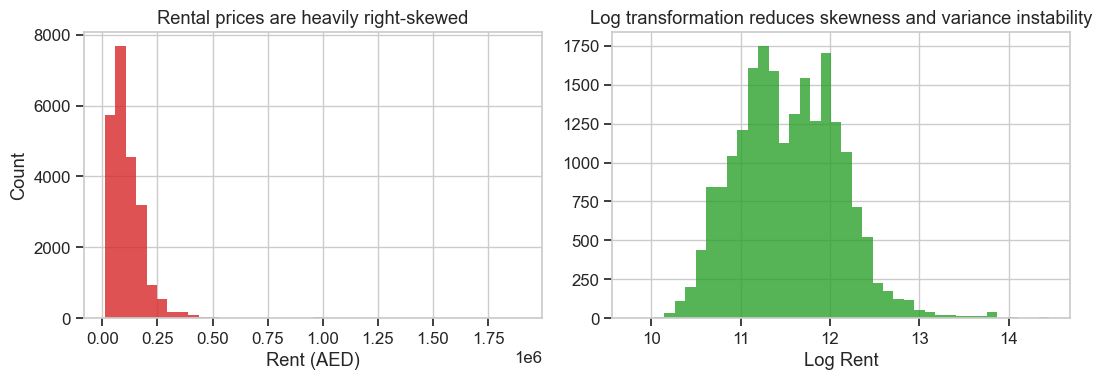


Skewness (Raw): 5.698576878036277

Skewness (Log): 0.39153118474081594


In [21]:
# Comparing raw rent vs log rent distribution (after cleaning)
fig, ax = plt.subplots(1,2, figsize=(11,4))

# Raw rent
ax[0].hist(df_clean['Rent'], bins=40, color=COLORS["bad"], alpha=0.8)
ax[0].set_title("Rental prices are heavily right-skewed")
ax[0].set_xlabel("Rent (AED)")
ax[0].set_ylabel("Count")

# Log rent
ax[1].hist(df_abu_dhabi['Log_Rent'], bins=40, color=COLORS["good"], alpha=0.8)
ax[1].set_title("Log transformation reduces skewness and variance instability")
ax[1].set_xlabel("Log Rent")

plt.tight_layout()
plt.show()
print()
print("Skewness (Raw):", df_clean['Rent'].skew())
print()
print("Skewness (Log):", df_abu_dhabi['Log_Rent'].skew())

#### Is rent proportional to size?
Linear regression assumes rent increases proportionally with area 
  To verify this assumption we examine how rent changes across increasing property sizes

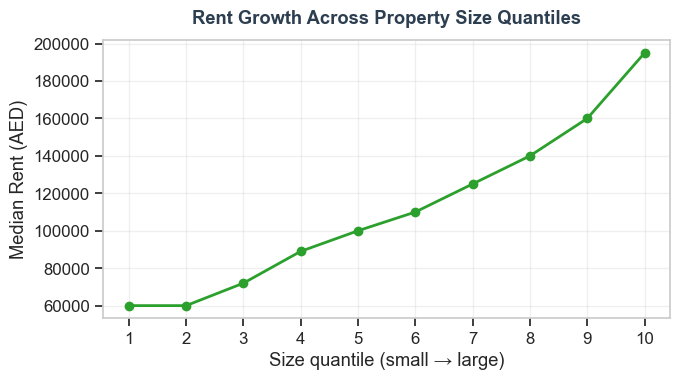

In [22]:
# Non-linear size effect

df_curve = df_abu_dhabi.copy()
df_curve["Area_bin"] = pd.qcut(df_curve["Area_in_sqft"], q=10)

area_curve = df_curve.groupby("Area_bin")["Rent"].median()

plt.figure(figsize=(7,4))

plt.plot(
    area_curve.values,
    marker="o",
    color=COLORS["good"],
    linewidth=2
)

plt.xticks(range(len(area_curve.index)), [str(i+1) for i in range(len(area_curve.index))], rotation=0)

style_plot(
    "Rent Growth Across Property Size Quantiles",
    "Size quantile (small → large)",
    "Median Rent (AED)"
)

plt.show()

The relationship b/w rent & area is non-linear.
Rent increases rapidly for smaller properties but shows diminishing returns as size grows.
This violates the constant slope assumption of linear regression & motivates the use of tree based models

### Does property type matter beyond size?
Larger properties naturally have higher rent, so comparing raw rent across property types can be misleading.
To determine whether certain property types are inherently premium, we compare rent normalized by size (price per sqft)

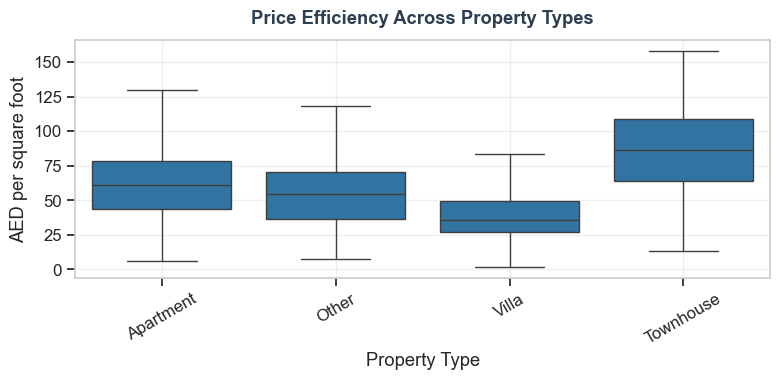

Median Price per Sqft (AED)


Type_grouped
Townhouse    86.11
Apartment    61.11
Other        54.17
Villa        35.71
Name: Price_per_sqft, dtype: float64

In [23]:
# Price per sqft analysis
df_analysis = df_abu_dhabi.copy()
df_analysis["Price_per_sqft"] = df_analysis["Rent"] / df_analysis["Area_in_sqft"]

plt.figure(figsize=(8,4))

sns.boxplot(
    data=df_analysis,
    x="Type_grouped",
    y="Price_per_sqft",
    color=COLORS["primary"],
    showfliers=False
)

plt.xticks(rotation=30)

style_plot(
    "Price Efficiency Across Property Types",
    "Property Type",
    "AED per square foot"
)

plt.show()

#summary
price_summary = (
    df_analysis.groupby("Type_grouped")["Price_per_sqft"]
    .median()
    .sort_values(ascending=False)
    .round(2)
)

print("Median Price per Sqft (AED)")
display(price_summary)

Although villas have higher total rents due to larger sizes, they have the lowest price per square foot.
Townhouses command the highest price per unit area which indicates that buyers pay a premium for space efficiency rather than total size

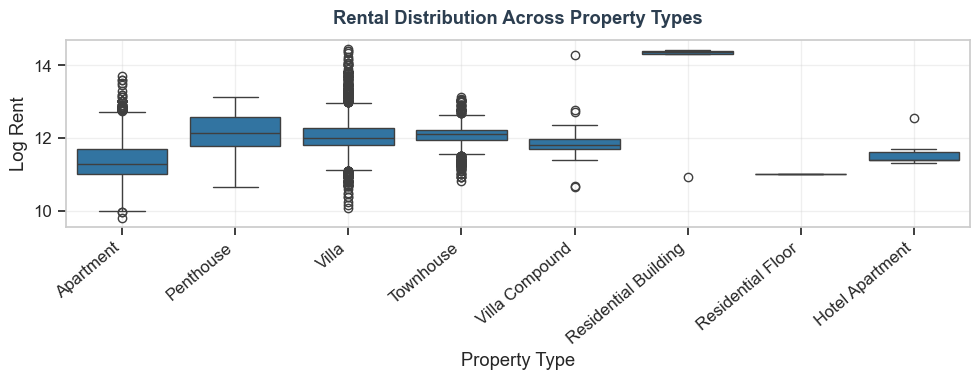

In [24]:
# Relationship b/w property type & rental price
plt.figure(figsize=(10,4))

sns.boxplot(
    data=df_abu_dhabi,
    x="Type",
    y="Log_Rent",
    color=COLORS["primary"]
)

plt.xticks(rotation=40, ha="right")

style_plot(
    "Rental Distribution Across Property Types",
    "Property Type",
    "Log Rent"
)

plt.show()


#### Do older listings reduce price?
Properties that remain listed longer may be overpriced or less desirable.
We examine whether listing age is associated with lower rental price

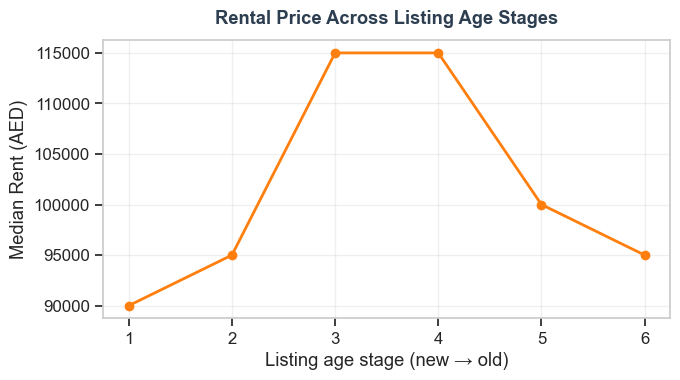

In [25]:
# Listing age vs rent
df_age = df_abu_dhabi.copy()
df_age["Age_bin"] = pd.qcut(df_age["Age_of_listing_in_days"], q=6)

age_curve = df_age.groupby("Age_bin")["Rent"].median()

plt.figure(figsize=(7,4))

plt.plot(
    age_curve.values,
    marker="o",
    color=COLORS["secondary"],
    linewidth=2
)

plt.xticks(range(len(age_curve.index)), [str(i+1) for i in range(len(age_curve.index))], rotation=0)

style_plot(
    "Rental Price Across Listing Age Stages",
    "Listing age stage (new → old)",
    "Median Rent (AED)"
)

plt.show()

Rental price follows a lifecycle pattern rather than a monotonic decrease. 
New listings tend to start lower, prices peak after market exposure & older listings decline due to price correction. 
This non-linear temporal behaviour further supports the use of non-linear models

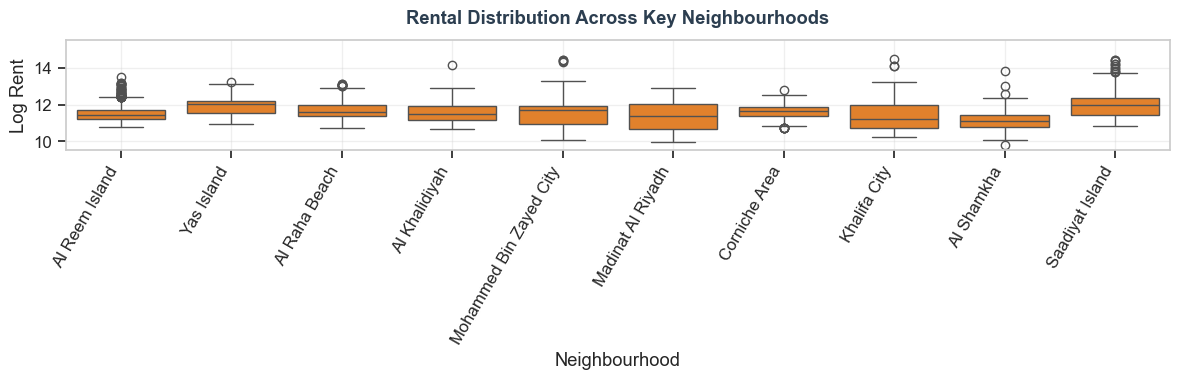

In [26]:
# Rent variation across major neighbourhoods
top_locations = df_abu_dhabi["Location"].value_counts().head(10).index
loc_df = df_abu_dhabi[df_abu_dhabi["Location"].isin(top_locations)]

plt.figure(figsize=(12,4))

sns.boxplot(
    data=loc_df,
    x="Location",
    y="Log_Rent",
    color=COLORS["secondary"]
)

plt.xticks(rotation=60, ha="right")
plt.ylim(9.5, 15.5)

style_plot(
    "Rental Distribution Across Key Neighbourhoods",
    "Neighbourhood",
    "Log Rent"
)

plt.show()


Rental pricing exhibits clear neighbourhood level baselines, reinforcing the importance of location aware modeling

### Encoding & Train-Test Split

Before training any models, we split the dataset into training & test sets.
Location has a strong influence on rent, so we apply target encoding but only using training data, to avoid data leakage

In [27]:
#train-test split + target encoding for Location= Location_TE
from sklearn.model_selection import train_test_split

# working df: df_abu_dhabi
df = df_abu_dhabi.copy()

# 1) splitting
train_df, test_df = train_test_split(df, test_size=0.20, random_state=42)
train_df = train_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)
print("Train / Test shapes:", train_df.shape, test_df.shape)

# 2) computing smoothing target encoding on training data only
loc_col = 'Location'
target_col = 'Log_Rent'
smoothing = 10.0   # larger = stronger shrinkage toward global mean (safer for small groups)
min_samples = 5    # if count < min_samples, we'll fall back to global mean

# aggregating
agg = train_df.groupby(loc_col)[target_col].agg(['mean','count']).rename(columns={'mean':'loc_mean','count':'loc_count'})
global_mean = train_df[target_col].mean()

# smoothing formula
agg['weight'] = agg['loc_count'] / (agg['loc_count'] + smoothing)
agg['Location_TE'] = agg['weight'] * agg['loc_mean'] + (1 - agg['weight']) * global_mean

# for very small groups, setting Location_TE to global_mean to avoid noisy encodings
agg.loc[agg['loc_count'] < min_samples, 'Location_TE'] = global_mean

# mapping
loc_te_map = agg['Location_TE'].to_dict()

# 3) mappimg into train & test
train_df['Location_TE'] = train_df[loc_col].map(loc_te_map).fillna(global_mean)
test_df['Location_TE'] = test_df[loc_col].map(loc_te_map).fillna(global_mean)

# 4) droping raw Location column 
train_df = train_df.drop(columns=[loc_col])
test_df  = test_df.drop(columns=[loc_col])

print("\nLocations encoded (train):", len(agg))
print("Global mean (train Log_Rent):", round(global_mean,4))
print("\nTop 10 encoded locations (by loc_count):")
display(agg.sort_values('loc_count', ascending=False).head(10)[['loc_count','loc_mean','Location_TE']])

X_train_df = train_df.copy()
X_test_df = test_df.copy()


Train / Test shapes: (16860, 13) (4215, 13)

Locations encoded (train): 85
Global mean (train Log_Rent): 11.5404

Top 10 encoded locations (by loc_count):


,loc_count,loc_mean,Location_TE
Location,,,
Al Reem Island,2757,11.466098,11.466367
Khalifa City,1503,11.385313,11.386338
Mohammed Bin Zayed City,1434,11.502662,11.502924
Al Raha Beach,1367,11.669610,11.668671
Yas Island,882,11.945438,11.940897
Al Khalidiyah,682,11.538686,11.538710
Madinat Al Riyadh,535,11.345191,11.348772
Saadiyat Island,506,11.976194,11.967748
Corniche Area,488,11.633954,11.632075


The model is trained to predict Log_Rent.
To avoid target leakage, both Log_Rent & raw Rent are removed from the feature matrix before training

In [28]:
# Separating target from features
target = 'Log_Rent'

y_train = X_train_df[target]
y_test  = X_test_df[target]

X_train = X_train_df.drop(columns=['Log_Rent','Rent'])
X_test  = X_test_df.drop(columns=['Log_Rent','Rent'])

print("Training feature shape:", X_train.shape)
print("Testing feature shape:", X_test.shape)

Training feature shape: (16860, 11)
Testing feature shape: (4215, 11)


In [29]:
#Final features 

model_features = [
    'Beds',
    'Baths',
    'Area_in_sqft',
    'Age_of_listing_in_days',
    'Total_Rooms',
    'Room_Density',
    'Location_TE',
    'Type_grouped',
    'Furnishing_clean'
]

X_train = X_train[model_features].copy()
X_test  = X_test[model_features].copy()

print("Final features used:", list(X_train.columns))
print("Train shape:", X_train.shape, " Test shape:", X_test.shape)

Final features used: ['Beds', 'Baths', 'Area_in_sqft', 'Age_of_listing_in_days', 'Total_Rooms', 'Room_Density', 'Location_TE', 'Type_grouped', 'Furnishing_clean']
Train shape: (16860, 9)  Test shape: (4215, 9)


In [30]:
# Baseline model: predicting global mean log rent
baseline_pred_log = np.full(len(y_test), y_train.mean())

# Converting to AED & computing RMSE
baseline_rmse = np.sqrt(
    mean_squared_error(np.expm1(y_test), np.expm1(baseline_pred_log))
)

print("Baseline RMSE:", round(baseline_rmse, 2), "AED")

BASELINE_RMSE = baseline_rmse

Baseline RMSE: 88426.14 AED


The baseline model (predicting mean log rent) yields an RMSE of 88,426 AED. All trained models are evaluated relative to this naive benchmark

In [31]:
# Defining numeric & categorical feature

numeric_features = [
    "Beds",
    "Baths",
    "Area_in_sqft",
    "Age_of_listing_in_days",
    "Total_Rooms",
    "Room_Density",
    "Location_TE"
]

categorical_features = [
    "Type_grouped",
    "Furnishing_clean"
]

print("Numeric features:", numeric_features)
print("Categorical features:", categorical_features)

Numeric features: ['Beds', 'Baths', 'Area_in_sqft', 'Age_of_listing_in_days', 'Total_Rooms', 'Room_Density', 'Location_TE']
Categorical features: ['Type_grouped', 'Furnishing_clean']


In [32]:
# Common evaluation function (used for all models)
def evaluate_model(model, X_test, y_test, model_name="Model"):
    
    # Predicting in log space
    pred_log = model.predict(X_test)
    
    # Converting to AED
    pred_rent = np.expm1(pred_log)
    true_rent = np.expm1(y_test)
    
    # Metrics
    mae = mean_absolute_error(true_rent, pred_rent)
    mse = mean_squared_error(true_rent, pred_rent)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, pred_log)
    
    print(f"\n{model_name}")
    print("---------------")
    print("MAE (AED):", round(mae,2))
    print("RMSE (AED):", round(rmse,2))
    print("R2 Score:", round(r2,4))
    
    return mae, rmse, r2


In [33]:
# Global model prepocessor
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

##  MODEL-01: Linear Regression

In [34]:
#Linear Regression (Pipeline)
lr_model = Pipeline([
    ('prep', ColumnTransformer([
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])),
    ('model', LinearRegression())
])

lr_model.fit(X_train, y_train)
mae_lr, rmse_lr, r2_lr = evaluate_model(
    lr_model,
    X_test,
    y_test,
    "Linear Regression"
)


Linear Regression
---------------
MAE (AED): 30847.96
RMSE (AED): 58854.12
R2 Score: 0.7315


Linear Regression provides a useful baseline model.  
However, rental pricing is unlikely to follow a strictly linear pattern, especially in premium markets where threshold effects & location premiums may exist

## MODEL-02: Ridge Regression

Regularization strength (alpha) is selected via 5 fold cross-validation to avoid arbitrary hyperparameter choice

In [35]:
#Ridge Regression (with alpha tuning via CV)

# Defining alphas
alphas = [0.01, 0.1, 1, 10, 50, 100]

ridge_model = Pipeline([
    ('prep', ColumnTransformer([
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])),
    ('model', RidgeCV(alphas=alphas, cv=5))
])

# Training
ridge_model.fit(X_train, y_train)

# Best alpha chosen by cross-validation
best_alpha = ridge_model.named_steps['model'].alpha_
print("Best alpha selected by CV:", best_alpha)

# Evaluating
mae_ridge, rmse_ridge, r2_ridge = evaluate_model(
    ridge_model,
    X_test,
    y_test,
    "Ridge Regression (CV)"
)

Best alpha selected by CV: 1.0

Ridge Regression (CV)
---------------
MAE (AED): 30847.25
RMSE (AED): 58852.11
R2 Score: 0.7315


Regularization through Ridge slightly stabilizes the coefficients but overall performance remains similar to the basic linear model.  
This suggests that the limitation is not overfitting but rather the linear assumption itself

## MODEL-03: Random Forest Global

In [36]:
rf_model = Pipeline([
    ('prep', ColumnTransformer([
        ('num', 'passthrough', numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])),
    ('model', RandomForestRegressor(n_estimators=300, max_depth=14, random_state=42, n_jobs=-1))
])

rf_model.fit(X_train, y_train)
mae_rf, rmse_rf, r2_rf = evaluate_model(
    rf_model,
    X_test,
    y_test,
    "Random Forest"
)


Random Forest
---------------
MAE (AED): 18331.12
RMSE (AED): 42046.94
R2 Score: 0.8858


The substantial performance improvement indicates that rental pricing relationships are non-linear.  

Tree based models are able to capture interactions & threshold effects that linear models cannot represent

## MODEL-04: Gradient Boosting

In [37]:
gb_model = Pipeline([
    ('prep', ColumnTransformer([
        ('num', 'passthrough', numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])),
    ('model', GradientBoostingRegressor(
        n_estimators=300,
        learning_rate=0.05,
        max_depth=3,
        random_state=42
    ))
])

# training
gb_model.fit(X_train, y_train)

# evaluation
mae_gb, rmse_gb, r2_gb = evaluate_model(
    gb_model,
    X_test,
    y_test,
    "Gradient Boosting"
)


Gradient Boosting
---------------
MAE (AED): 21628.09
RMSE (AED): 43812.27
R2 Score: 0.8569


## MODEL-05: Neural Network

Although tree based ensembles perform strongly on structured tabular data, I included a small Multilayer Perceptron (MLP) experiment to evaluate whether a non-linear neural approach could further improve predictive performance

In [38]:
#Neural Network (MLP Regressor)

mlp_model = Pipeline([
    ('prep', ColumnTransformer([
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])),
    ('model', MLPRegressor(
        hidden_layer_sizes=(64, 32),
        activation='relu',
        solver='adam',
        learning_rate_init=0.001,
        max_iter=500,
        random_state=42
    ))
])

# Training
mlp_model.fit(X_train, y_train)

# Evaluation
mae_mlp, rmse_mlp, r2_mlp = evaluate_model(
    mlp_model,
    X_test,
    y_test,
    "Neural Network (MLP)"
)


Neural Network (MLP)
---------------
MAE (AED): 25728.5
RMSE (AED): 51013.39
R2 Score: 0.7926


### Feature Importance from global RF

In [39]:
preprocessor = rf_model.named_steps["prep"]
ohe = preprocessor.named_transformers_["cat"]
cat_features = ohe.get_feature_names_out(categorical_features)

all_features = numeric_features + list(cat_features)
importances = rf_model.named_steps["model"].feature_importances_

feat_imp = (
    pd.Series(importances, index=all_features)
    .sort_values(ascending=False)
    .round(4)
)

print("Top Feature Importances")
display(feat_imp.head(10))

Top Feature Importances


Baths                           0.5673
Location_TE                     0.2048
Total_Rooms                     0.0812
Area_in_sqft                    0.0561
Room_Density                    0.0325
Age_of_listing_in_days          0.0260
Furnishing_clean_unfurnished    0.0080
Beds                            0.0070
Furnishing_clean_furnished      0.0069
Type_grouped_Apartment          0.0033
dtype: float64

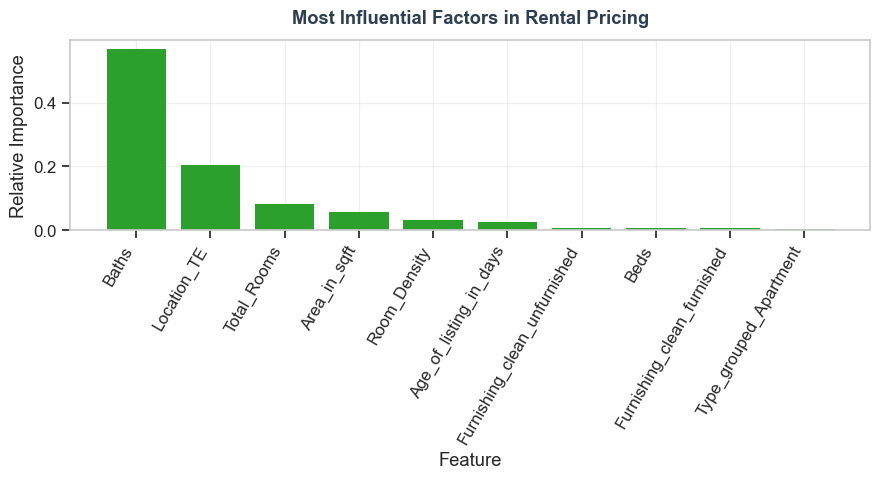

In [40]:
top_imp = feat_imp.head(10)

plt.figure(figsize=(9,5))
plt.bar(top_imp.index, top_imp.values, color=COLORS["good"])

plt.xticks(rotation=60, ha="right")

style_plot(
    "Most Influential Factors in Rental Pricing",
    "Feature",
    "Relative Importance"
)

plt.show()

Feature importance analysis from the final Random Forest model shows that the number of bathrooms is the strongest predictor of rental price, followed by location encoding & total rooms.
This indicates that structural comfort & neighborhood hierarchy are primary drivers of rental valuation.
Areaa related variables such as square footage & room density contribute meeaningfully but less than core structural features. Furnishing status & property type have relatively lower marginal impact once major structural & location effects are accounted for

### Error analysis for Random Forest

In [41]:
pred_log = rf_model.predict(X_test)
pred_rent = np.expm1(pred_log)
true_rent = np.expm1(y_test)

errors = pred_rent - true_rent

error_df = X_test.copy()
error_df['True_Rent'] = true_rent
error_df['Pred_Rent'] = pred_rent
error_df['Error'] = errors
error_df['Abs_Error'] = np.abs(errors)

print("Overall MAE:", error_df['Abs_Error'].mean())

# checking expensive properties
luxury = error_df[error_df['True_Rent'] > error_df['True_Rent'].quantile(0.9)]
normal = error_df[error_df['True_Rent'] <= error_df['True_Rent'].quantile(0.9)]

print("\nMAE normal properties:", normal['Abs_Error'].mean())
print("MAE luxury properties:", luxury['Abs_Error'].mean())


Overall MAE: 18331.118236215305

MAE normal properties: 13047.919621952364
MAE luxury properties: 71804.3369283331


Given the elevated error observed in the highest price segment, we explore a segmented modeling approach to determine whether specialized models improve prediction accuracy

In [42]:
# Defining luxury threshold from training data
luxury_threshold = np.expm1(y_train).quantile(0.9)

print("Luxury threshold (AED):", round(luxury_threshold,2))


Luxury threshold (AED): 209000.0


In [43]:
# Spliting training data into segments
train_rent = np.expm1(y_train)

normal_mask_train = train_rent <= luxury_threshold
luxury_mask_train = train_rent > luxury_threshold

X_train_normal = X_train[normal_mask_train]
y_train_normal = y_train[normal_mask_train]

X_train_luxury = X_train[luxury_mask_train]
y_train_luxury = y_train[luxury_mask_train]

print("Normal training size:", len(X_train_normal))
print("Luxury training size:", len(X_train_luxury))


Normal training size: 15176
Luxury training size: 1684


We train separate Random Forest models for normal and luxury segments to handle different pricing behavior

In [44]:
# Normal segment model
rf_normal = Pipeline([
    ('prep', ColumnTransformer([
        ('num', 'passthrough', numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])),
    ('model', RandomForestRegressor(
        n_estimators=200,
        max_depth=12,
        random_state=42,
        n_jobs=-1
    ))
])

# Luxury segment model
rf_luxury = Pipeline([
    ('prep', ColumnTransformer([
        ('num', 'passthrough', numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])),
    ('model', RandomForestRegressor(
        n_estimators=300,   # slightly more trees for harder segment
        max_depth=14,
        random_state=42,
        n_jobs=-1
    ))
])

# Train models
rf_normal.fit(X_train_normal, y_train_normal)
rf_luxury.fit(X_train_luxury, y_train_luxury)

print("Segment models trained.")


Segment models trained.


During inference, the true rent is unknown.
Therefore the global model is first used to estimate the property segment after which the corresponding specialized model makes the final prediction

In [45]:
# Segmented prediction

# Step 1: global prediction
global_pred_log = rf_model.predict(X_test)
global_pred_rent = np.expm1(global_pred_log)

# Step 2: deciding segment using predicted rent
normal_mask_test = global_pred_rent <= luxury_threshold
luxury_mask_test = global_pred_rent > luxury_threshold

# Step 3: allocating prediction array
final_pred_log = np.zeros(len(X_test))

# normal prop.
final_pred_log[normal_mask_test] = rf_normal.predict(X_test[normal_mask_test])

# luxury prop.
final_pred_log[luxury_mask_test] = rf_luxury.predict(X_test[luxury_mask_test])

print("Segment routing complete")


Segment routing complete


We compare the segmented model against the single global Random Forest

In [46]:
# Evaluating segmented model
seg_pred_rent = np.expm1(final_pred_log)
true_rent = np.expm1(y_test)

mae = mean_absolute_error(true_rent, seg_pred_rent)
rmse = np.sqrt(mean_squared_error(true_rent, seg_pred_rent))
r2 = r2_score(y_test, final_pred_log)

print("Segmented Random Forest")
print("--------------------------")
print("MAE (AED):", round(mae,2))
print("RMSE (AED):", round(rmse,2))
print("R2 Score:", round(r2,4))


Segmented Random Forest
--------------------------
MAE (AED): 20009.0
RMSE (AED): 46454.39
R2 Score: 0.8686


Although a segmented modeling approach was explored, it did not outperform the global Random Forest model. This indicates that the global ensemble already captures segment level pricing behavior effectively. Therefore the single Random Forest model is retained as the primary production model

In [47]:
results = pd.DataFrame({
    "Model": [
        "Linear Regression",
        "Ridge Regression",
        "Random Forest",
        "Gradient Boosting",
        "Neural Network (MLP)"
    ],
    "MAE (AED)": [
        mae_lr,
        mae_ridge,
        mae_rf,
        mae_gb,
        mae_mlp
    ],
    "RMSE (AED)": [
        rmse_lr,
        rmse_ridge,
        rmse_rf,
        rmse_gb,
        rmse_mlp
    ],
    "R2 Score": [
        r2_lr,
        r2_ridge,
        r2_rf,
        r2_gb,
        r2_mlp
    ]
})

results = results.sort_values("RMSE (AED)")

results

,Model,MAE (AED),RMSE (AED),R2 Score
2,Random Forest,18331.118236,42046.935984,0.885793
3,Gradient Boosting,21628.085941,43812.265502,0.856913
4,Neural Network (MLP),25728.504245,51013.393107,0.792585
1,Ridge Regression,30847.253911,58852.110434,0.731493
0,Linear Regression,30847.963504,58854.124825,0.731489


Across all evaluated models, tree-based ensemble methods consistently outperformed linear models & the neural network. Random Forest achieved the lowest prediction error, suggesting that rental pricing depends on non-linear relationships & feature interactions. The neural network did not provide additional performance gains which aligns with existing research showing that tree ensembles often perform better on structured tabular data

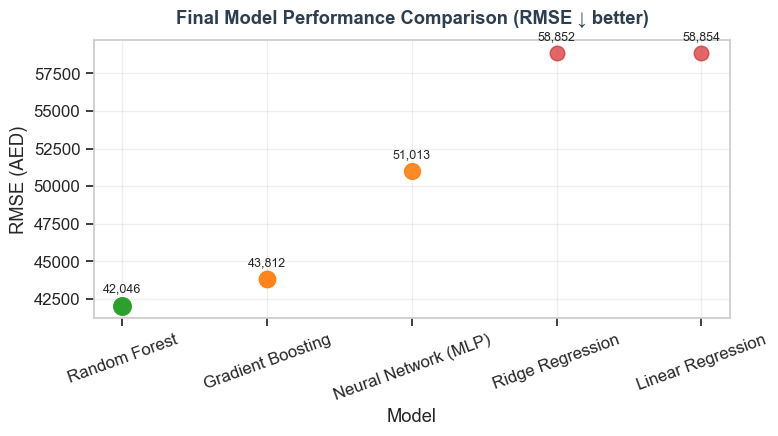

In [48]:
# Final Model Ranking (RMSE ↓ better)
sorted_models = results["Model"].tolist()
sorted_rmse = results["RMSE (AED)"].tolist()

plt.figure(figsize=(8, 4))

for model, score in zip(sorted_models, sorted_rmse):

    if model == "Random Forest":
        color = COLORS["good"]
        size = 160
        alpha = 1.0

    elif model == "Gradient Boosting":
        color = COLORS["secondary"]
        size = 140
        alpha = 0.95

    elif model == "Neural Network (MLP)":
        color = COLORS["secondary"]
        size = 130
        alpha = 0.9

    else:  # Linear & Ridge
        color = COLORS["bad"]
        size = 110
        alpha = 0.7

    plt.scatter(model, score, color=color, s=size, alpha=alpha)
    plt.text(model, score + 900, f"{int(score):,}", ha="center", fontsize=9)

style_plot(
    "Final Model Performance Comparison (RMSE ↓ better)",
    "Model",
    "RMSE (AED)"
)

plt.xticks(rotation=20)
plt.show()

#### Model ranking by prediction error
-Models are ordered by RMSE (lower is better)

-Best model for this dataset - RANDOM FOREST

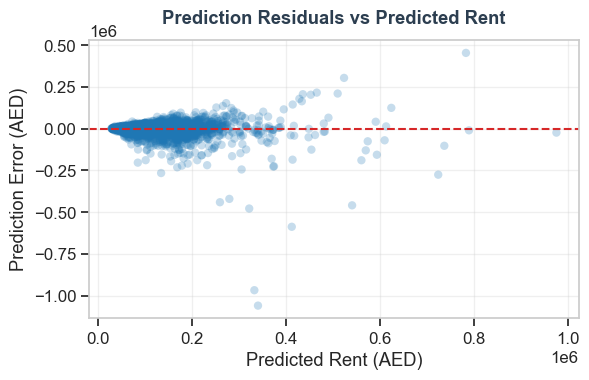

In [49]:
# Residual analysis (global RF)

pred_log = rf_model.predict(X_test)
pred_rent = np.expm1(pred_log)
true_rent = np.expm1(y_test)

residuals = pred_rent - true_rent

plt.figure(figsize=(6,4))

plt.scatter(
    pred_rent,
    residuals,
    alpha=0.25,
    color=COLORS["primary"],
    edgecolors="none"
)

plt.axhline(0, linestyle="--", color=COLORS["bad"], linewidth=1.5)

style_plot(
    "Prediction Residuals vs Predicted Rent",
    "Predicted Rent (AED)",
    "Prediction Error (AED)"
)

plt.show()

The residual plot shows increasing dispersion as predicted rent increases, indicating heteroscedastic behavior.

Prediction errors grow for high value properties, suggesting that luxury pricing depends on factors not captured in the current feature set

#### Where does the model make mistakes?
To understand practical reliability, we analyze prediction error across different rent ranges

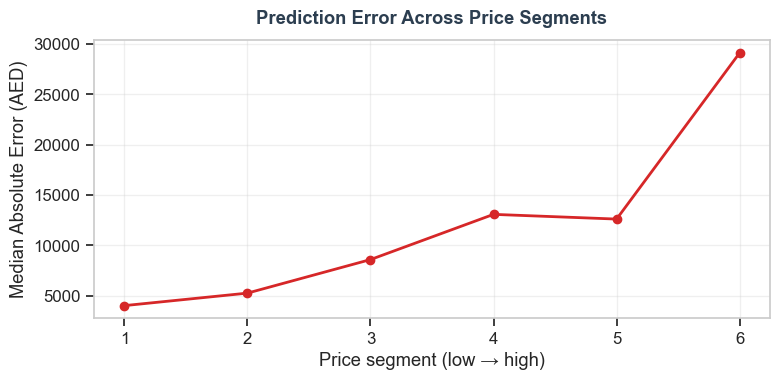

In [50]:
# Error vs price range (Random Forest)

rf_pred = rf_model.predict(X_test)

error_df = pd.DataFrame({
    "Actual": np.expm1(y_test),
    "Predicted": np.expm1(rf_pred)
})

error_df["Absolute_Error"] = abs(error_df["Actual"] - error_df["Predicted"])

# price bins
error_df["Price_range"] = pd.qcut(error_df["Actual"], q=6)
range_error = error_df.groupby("Price_range")["Absolute_Error"].median()

plt.figure(figsize=(8,4))

plt.plot(
    range_error.values,
    marker="o",
    color=COLORS["bad"],
    linewidth=2
)

plt.xticks(range(len(range_error.index)), [str(i+1) for i in range(len(range_error.index))])

style_plot(
    "Prediction Error Across Price Segments",
    "Price segment (low → high)",
    "Median Absolute Error (AED)"
)

plt.show()

Median absolute error increases steadily across price segments.

The model performs reliably for lower & mid market rentals but struggles in the upper price range.  
This pattern suggests a data limitation rather than model instability

## Final Findings

This study examined rental price prediction in Abu Dhabi using structural property attributes & neighborhood level location information

Exploratory analysis revealed clear non linear pricing dynamics. Rental prices do not increase proportionally with property size, listing age follows a lifecycle pattern & neighbourhoods exhibit distinct pricing baselines. These patterns limit the effectiveness of purely linear models

Among the evaluated approaches tree-based ensemble methods delivered the strongest performance. Random Forest achieved the lowest prediction error, demonstrating its ability to capture non-linear feature interactions & heterogeneous neighbourhood effects. Gradient Boosting performed competitively but did not surpass Random Forest

Linear and Ridge regression provided stable baseline performance but were constrained by their linear assumptions
The neural network experiment did not outperform ensemble methods reinforcing the empirical observation that tree-based models often excel on structured tabular datasets

Overall, rental pricing in Abu Dhabi is influenced by complex structural & neighbuorhood level interactions. Flexible ensemble methods align better with this behavior & provide more reliable predictive accuracy than global linear approximations